折1，训练log rmse1.188077, 验证log rmse1.245331
折2，训练log rmse1.199653, 验证log rmse1.188166
折3，训练log rmse1.215246, 验证log rmse1.099568
折4，训练log rmse1.172926, 验证log rmse1.259857
折5，训练log rmse1.175061, 验证log rmse1.237375
5-折验证: 平均训练log rmse: 1.190193, 平均验证log rmse: 1.206059


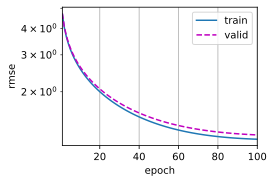

In [3]:
import hashlib
import os
import tarfile
import zipfile
import requests

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import tools.tool_pytorch_017 as ty
        
train_data = pd.read_csv('./data_sets/kaggle_house_price_train.csv')
test_data = pd.read_csv('./data_sets/kaggle_house_price_test.csv')

# print(train_data.shape)
# print(test_data.shape)

# print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
'''
    数据清洗
'''
# 训练数据去掉id列
all_features = pd.concat((train_data.iloc[0:5000, 1:-1], test_data.iloc[0:5000, 1:]))

# pandas三种数据类型 int64（一列均为整数），float64（一列均为浮点数），object（只要该列带字符类型就是object）。
# 判断数据集每列是否为字符串
# print(all_features.dtypes != 'object')
# 查找所有不是字符串类型的列是什么类型int64/float64
# print(all_features.dtypes[all_features.dtypes != 'object'])
# 找出所有非字符串类型的列
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

# print(all_features[numeric_features])
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# print(all_features[numeric_features])
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
# print(all_features[numeric_features])
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
# one hot encode 独热编码，又称一位有效编码，其方法是使用N位状态寄存器来对N个状态进行编码，每个状态都有它独立的寄存器位，并且在任意时候，其中只有一位有效。
# 转换独热编码后，数据中存在True/False，需要转码成1/0
all_features = pd.get_dummies(all_features, prefix=None, prefix_sep='_', dummy_na=True, columns=None, sparse=False, drop_first=False).astype(int)
# print(all_features)

# n_train = train_data.shape[0]
n_train = 10000
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 取出训练集的售价字段作为labels
train_labels = torch.tensor(
    train_data.iloc[0:10000, 2:3].values.reshape(-1, 1), dtype=torch.float32)

# print(train_features)
# print(test_features)

'''
    构建模型
'''
loss = nn.MSELoss()
in_features = train_features.shape[1]

# 构造感知机
def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

def log_rmse(net, features, labels):
    '''
        房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。 因此，我们更关心相对误差， 而不是绝对误差。 
        例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时， 假设我们的预测偏差了10万美元， 然而那里一栋典型的房子的价值是12.5万美元， 那么模型可能做得很糟糕。 
        另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差， （在那里，房价中位数超过400万美元） 这可能是一个不错的预测。

        解决这个问题的一种方法是用价格预测的对数来衡量差异。 事实上，这也是比赛中官方用来评价提交质量的误差指标。
    '''
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = ty.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    '''
        K折交叉验证
        简单来说就是把数据集首尾对齐折叠K次，取第i个K作为训练集或测试集
    '''
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            ty.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    ty.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
# train_and_pred(train_features, test_features, train_labels, test_data,
#                num_epochs, lr, weight_decay, batch_size)

